**MAGNETIC UXO PROJECT**

This project tested the PhyPhox app to record magnetic measuremnts with an iPhone over a 20x20 m grid with 0.5 m line spacing. A 20x5 cm paint can was used to simulate a pUXO located at coordinate 10,10. The processing steps are detailed below:

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.interpolate import griddata
from scipy.signal import hilbert
from scipy.signal import find_peaks

1. Import the data and then grid up the raw data.

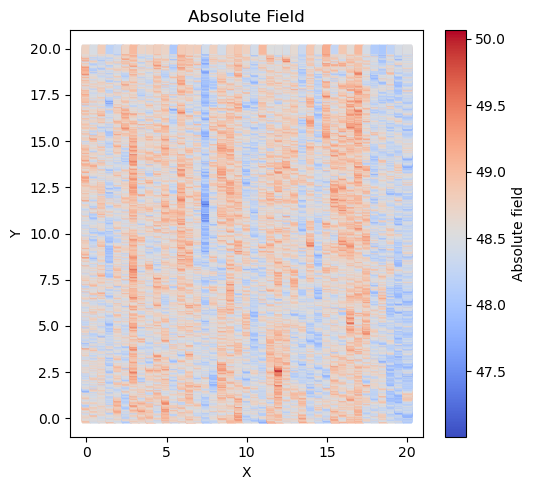

In [5]:
# Read the CSV file (replace 'your\file.csv' with the actual file path)
csv_file = r"your\file.csv"
df = pd.read_csv(csv_file)

# Assuming your CSV has columns 'X', 'Y', 'Absolute field'
x_values = df['X']
y_values = df['Y']
absolute_field = df['Absolute field']

# Create a plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(x_values, y_values, c=absolute_field, cmap='coolwarm', marker='s')
plt.colorbar(label='Absolute field')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Absolute Field')

plt.tight_layout()
plt.show()

2. Reorder the data into 'flights' based on line paths to accurately attain the moving median for each line.

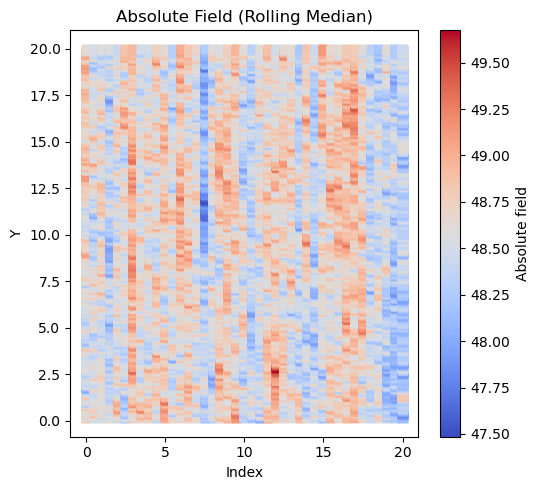

In [6]:
# Function to assign flight numbers based on 'X' values
def assign_flight_number(x):
    flight_number = 0
    previous_x = None
    flights = []
    for current_x in x:
        if previous_x is None or current_x - previous_x >= 0.5:
            flight_number += 1
        flights.append(flight_number)
        previous_x = current_x
    return flights

# Assign flight numbers to the dataframe
df['Flight'] = assign_flight_number(df['X'])

# Set 'X' column as the index
df.set_index('X', inplace=True)

# Window size for rolling statistics
window_size = 10

# Calculate rolling median for each flight
absolute_field_rolling = df.groupby('Flight')['Absolute field'].rolling(window=window_size).median().reset_index(level=0, drop=True)

# Create a plot for rolling statistics
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(df.index, df['Y'], c=absolute_field_rolling, cmap='coolwarm', marker='s')
plt.colorbar(label='Absolute field')
plt.xlabel('Index')
plt.ylabel('Y')
plt.title('Absolute Field (Rolling Median)')

plt.tight_layout()
plt.show()

3. Create a median high pass filter.

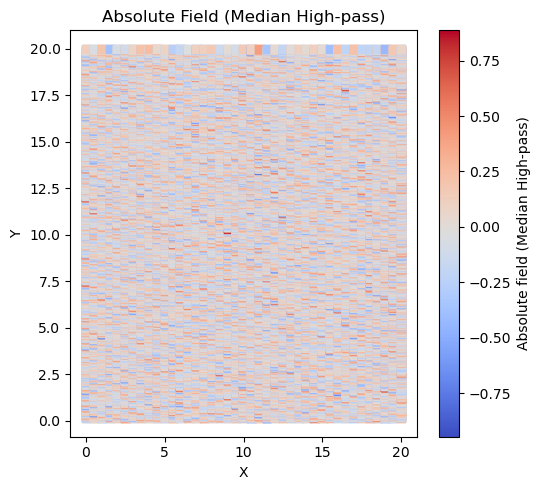

In [7]:
# Subtract rolling median from original data for median high-pass
absolute_field_high_pass = df['Absolute field'] - absolute_field_rolling

# Create a plot for median high-pass filtered data
plt.figure(figsize=(15, 5))

# Plot Absolute field (Median High-pass)
plt.subplot(1, 3, 1)
sc = plt.scatter(df.index, df['Y'], c=absolute_field_high_pass, cmap='coolwarm', marker='s')
plt.colorbar(sc, label='Absolute field (Median High-pass)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Absolute Field (Median High-pass)')

plt.tight_layout()
plt.show()

4. Scale down the data due to noise and density of data ready for interpolation.

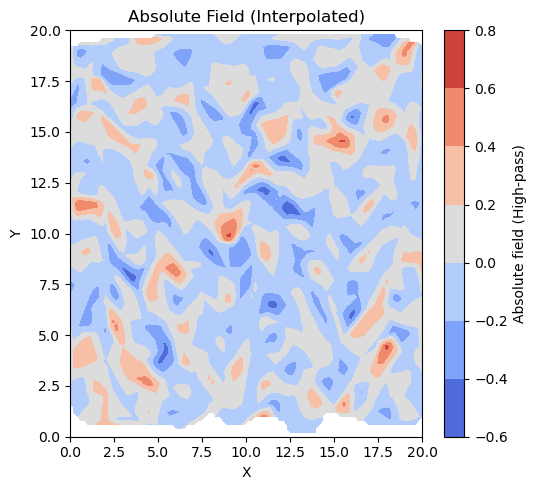

In [11]:
# Decimate the data by selecting every 100th point
decimation_factor = 100
x_decimated = x_values[::decimation_factor]
y_decimated = y_values[::decimation_factor]
absolute_field_decimated = absolute_field_high_pass.values[::decimation_factor]

# Create a coarser grid of points for interpolation
x_grid_coarse, y_grid_coarse = np.meshgrid(np.linspace(x_values.min(), x_values.max(), 100),
                                           np.linspace(y_values.min(), y_values.max(), 100))

# Interpolate the decimated data onto the coarse grid
absolute_field_interpolated = griddata((x_decimated, y_decimated), absolute_field_decimated, (x_grid_coarse, y_grid_coarse), method='linear')

# Plot contour maps for interpolated data
plt.figure(figsize=(15, 5))

# Plot Absolute field (Interpolated)
plt.subplot(1, 3, 2)
plt.contourf(x_grid_coarse, y_grid_coarse, absolute_field_interpolated, cmap='coolwarm')
plt.colorbar(label='Absolute field (High-pass)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Absolute Field (Interpolated)')

plt.tight_layout()
plt.show()

5. Generate the analytical signal from the interpolated dataset. 

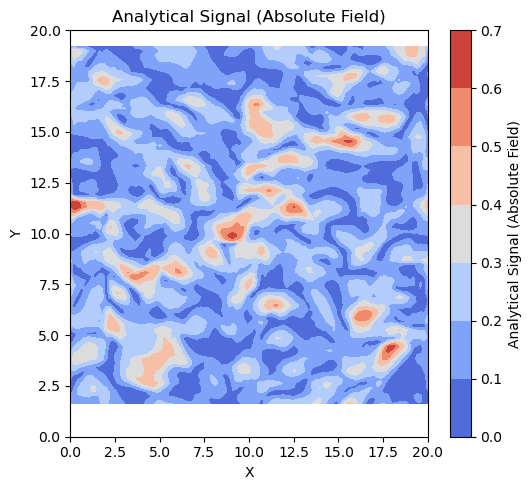

In [12]:
# Compute the analytical signal for each interpolated dataset
analytical_signal_absolute = hilbert(absolute_field_interpolated)

# Plot the contour maps for the analytical signal of the interpolated data
plt.figure(figsize=(15, 5))

# Plot Analytical signal of Absolute Field (Interpolated)
plt.subplot(1, 3, 1)
plt.contourf(x_grid_coarse, y_grid_coarse, np.abs(analytical_signal_absolute), cmap='coolwarm')
plt.colorbar(label='Analytical Signal (Absolute Field)')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Analytical Signal (Absolute Field)')

plt.tight_layout()
plt.show()

6. Show pUXO targets using the Blakely peak picking algorithm. 

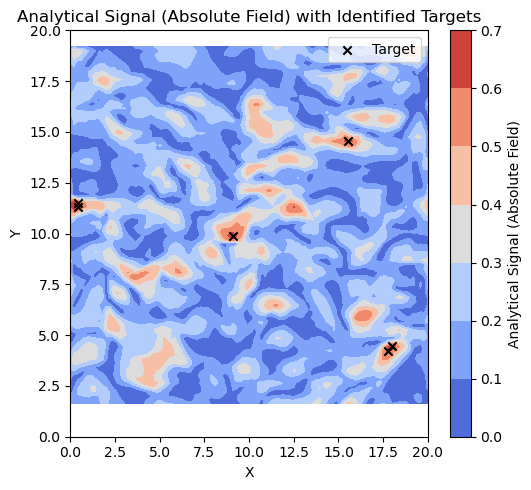

In [13]:
# Define peak detection function using Blakely peak picking algorithm
def blakely_peak_picking(signal):
    flattened_signal = signal.flatten()  # Flatten the input array
    peaks, _ = find_peaks(flattened_signal, prominence=0.6)  # Adjust prominence threshold as needed
    return peaks

# Apply peak detection function to the amplitude of the analytical signal
peaks_absolute = blakely_peak_picking(np.abs(analytical_signal_absolute))

# Extract coordinates of identified peaks
peak_coordinates = [(x_grid_coarse.flatten()[peak], y_grid_coarse.flatten()[peak]) for peak in peaks_absolute]

# Plot contour maps for the analytical signal with identified peaks
plt.figure(figsize=(15, 5))

# Plot Analytical signal of Absolute Field (Interpolated) with identified peaks
plt.subplot(1, 3, 1)
plt.contourf(x_grid_coarse, y_grid_coarse, np.abs(analytical_signal_absolute), cmap='coolwarm')
plt.colorbar(label='Analytical Signal (Absolute Field)')
plt.scatter([coord[0] for coord in peak_coordinates], [coord[1] for coord in peak_coordinates], color='black', marker='x', label='Target')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Analytical Signal (Absolute Field) with Identified Targets')
plt.legend()

plt.tight_layout()
plt.show()

7. Now create a function to calculate the window sizes of each target. Larger window sizes equal larger anomalies. 

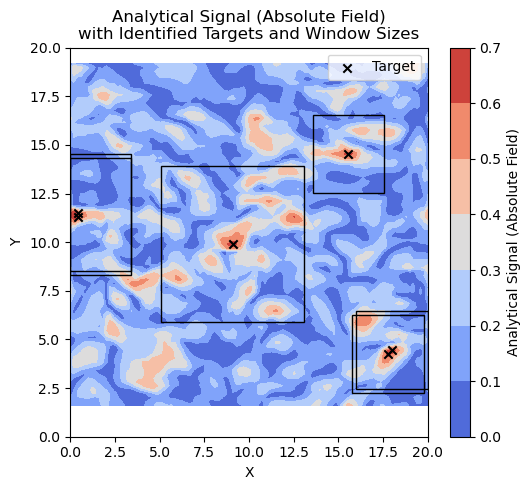

In [23]:
# Define the function to calculate window sizes for each target
def calculate_window_sizes(targets, neighborhood_radius):
    window_sizes = []
    for target in targets:
        x_target, y_target = target
        # Calculate distances from the target to all other points
        distances = np.sqrt((targets[:, 0] - x_target)**2 + (targets[:, 1] - y_target)**2)
        # Count the number of points within the neighborhood radius
        num_points_within_radius = np.sum(distances <= neighborhood_radius)
        # Window size is twice the number of points within the neighborhood radius
        window_size = 2 * num_points_within_radius
        window_sizes.append(window_size)
    return window_sizes

# Define the neighborhood radius (adjust as needed)
neighborhood_radius = 10

# Convert peak coordinates to NumPy array for easier manipulation
peak_coordinates_array = np.array(peak_coordinates)

# Calculate window sizes for each target
window_sizes = calculate_window_sizes(peak_coordinates_array, neighborhood_radius)

# Plot contour maps for the analytical signal with identified peaks and window sizes
plt.figure(figsize=(15, 5))

# Plot Analytical signal of Absolute Field (Interpolated) with identified peaks and window sizes
plt.subplot(1, 3, 1)
plt.contourf(x_grid_coarse, y_grid_coarse, np.abs(analytical_signal_absolute), cmap='coolwarm')
plt.colorbar(label='Analytical Signal (Absolute Field)')
plt.scatter([coord[0] for coord in peak_coordinates], [coord[1] for coord in peak_coordinates], color='black', marker='x', label='Target')

# Add black rectangles/squares for window sizes
for i, (x, y) in enumerate(peak_coordinates):
    window_size = window_sizes[i]
    x_left = max(x_grid_coarse.min(), x - window_size / 2)
    x_right = min(x_grid_coarse.max(), x + window_size / 2)
    y_bottom = max(y_grid_coarse.min(), y - window_size / 2)
    y_top = min(y_grid_coarse.max(), y + window_size / 2)
    rect_width = x_right - x_left
    rect_height = y_top - y_bottom
    if rect_width > 0 and rect_height > 0:
        rect = Rectangle((x_left, y_bottom), rect_width, rect_height, linewidth=1, edgecolor='black', facecolor='none')
        plt.gca().add_patch(rect)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Analytical Signal (Absolute Field)\nwith Identified Targets and Window Sizes')
plt.legend()

plt.tight_layout()
plt.show()

8. Finally export the target list as a .csv. Anomaly located at the centre appears to be the pUXO for testing.

In [24]:
# Create a pandas DataFrame to store target coordinates and window sizes
targets_df = pd.DataFrame({'X': peak_coordinates_array[:, 0], 'Y': peak_coordinates_array[:, 1], 'Window Size': window_sizes})

# Display the DataFrame
print(targets_df)

# Export targets_df to a CSV file
targets_df.to_csv(r'\Targets.csv', index=False)

           X          Y  Window Size
0  17.777778   4.242424            4
1  17.979798   4.444444            4
2   9.090909   9.898990            8
3   0.404040  11.313131            6
4   0.404040  11.515152            6
5  15.555556  14.545455            4
